# Dependencies and notebook settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
from IPython.core.display import display, HTML
import ngboost
from sklearn.tree import DecisionTreeRegressor
from multiprocessing import Pool
import os
from mp_cv import final_model_ver2
from var_test import *

display(HTML("<style>.container { width:90% !important; }</style>"))
plt.style.use("ggplot")
mpl.rcParams["figure.dpi"] = 100
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

# Data import 

In [2]:
df = pd.read_parquet("../dataset/spx_ngboost_final_dataset.parquet")
df = df.tail(4*252)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2016-09-29 to 2020-09-30
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rr                  1008 non-null   float64
 1   Volume_L1           1008 non-null   float64
 2   OBV_L1              1008 non-null   float64
 3   Volume_L2           1008 non-null   float64
 4   EMA_W_L1            1008 non-null   float64
 5   Open_stationary_L3  1008 non-null   float64
 6   MA_L1               1008 non-null   float64
 7   EMA_L1              1008 non-null   float64
 8   MA_2_L3             1008 non-null   float64
 9   MA_W_L2             1008 non-null   float64
 10  MA_W_L3             1008 non-null   float64
 11  Volume_L3           1008 non-null   float64
 12  ATR_L2              1008 non-null   float64
 13  OBV_L3              1008 non-null   float64
 14  EMA_W_L3            1008 non-null   float64
 15  ADOSC_L3            1008 non-null   f

In [3]:
features = df.columns.tolist()
features.remove("rr")

# NGBoost models estimation and VaR calculation

In the ensembling approach I will use simple average mean for QML-GARCH model (best GARCH model) and NGBoost models. I know that this methodology is very simple and rather inefficient - weights should be obtained in the cross-validation on training-validation sets (during 1,2,3 periods) but due to lack of time I will just do simple mean. 

In [4]:
NGBoost_all = list()

params = [["Laplace",0.01,100],
          ["Laplace",0.01,250],
          ["Laplace",0.01,500],
          ["T",0.01,100],
          ["T",0.01,250],
          ["T",0.1,250]]

if __name__ ==  '__main__': 
    for j in tqdm(params):
        train_test_setup = list()
        for i in range(0,252):
            train_test_setup.append([df.iloc[i : i + 252 * 3], df.iloc[i + 252 * 3 : i + 252 * 3 + 1], j[0], j[1], j[2]])
        num_proces = os.cpu_count()
        p = Pool(processes = num_proces)
        output = p.map(final_model_ver2, train_test_setup)
        NGBoost_all.append(output)
        p.close()
        p.join()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [17:35<00:00, 175.91s/it]


In [5]:
results_dict = {
    "rr":df.tail(252).rr.values,
    "NGBoostDistLaplaceEta001It100_1": np.array(NGBoost_all[0])[:,0].tolist(),
    "NGBoostDistLaplaceEta001It250_1": np.array(NGBoost_all[1])[:,0].tolist(),
    "NGBoostDistLaplaceEta001It500_1": np.array(NGBoost_all[2])[:,0].tolist(),
    "NGBoostDistLaplaceEta001It100_25": np.array(NGBoost_all[0])[:,1].tolist(),
    "NGBoostDistLaplaceEta001It250_25": np.array(NGBoost_all[1])[:,1].tolist(),
    "NGBoostDistLaplaceEta001It500_25": np.array(NGBoost_all[2])[:,1].tolist(),

    "NGBoostDistTEta001It100_1": np.array(NGBoost_all[3])[:,0].tolist(),
    "NGBoostDistTEta001It250_1": np.array(NGBoost_all[4])[:,0].tolist(),
    "NGBoostDistTEta01It250_1": np.array(NGBoost_all[5])[:,0].tolist(),
    "NGBoostDistTEta001It100_25": np.array(NGBoost_all[3])[:,1].tolist(),
    "NGBoostDistTEta001It250_25": np.array(NGBoost_all[4])[:,1].tolist(),
    "NGBoostDistTEta01It250_25": np.array(NGBoost_all[5])[:,1].tolist()}

results = pd.DataFrame(results_dict, index = df.tail(252).index)

In [6]:
results.head()

,rr,NGBoostDistLaplaceEta001It100_1,NGBoostDistLaplaceEta001It250_1,NGBoostDistLaplaceEta001It500_1,NGBoostDistLaplaceEta001It100_25,NGBoostDistLaplaceEta001It250_25,NGBoostDistLaplaceEta001It500_25,NGBoostDistTEta001It100_1,NGBoostDistTEta001It250_1,NGBoostDistTEta01It250_1,NGBoostDistTEta001It100_25,NGBoostDistTEta001It250_25,NGBoostDistTEta01It250_25
Date,,,,,,,,,,,,,
2019-10-02,-1.806544,-2.057183,-1.990776,-2.012317,-1.692013,-1.614624,-1.716313,-2.204719,-1.981894,-1.455088,-1.597090,-1.508708,-0.992742
2019-10-03,0.794038,-2.649158,-2.519590,-2.752310,-2.086717,-2.074562,-2.220623,-2.830190,-3.576916,-2.004499,-2.299535,-2.764178,-1.755022
2019-10-04,1.411674,-2.695972,-2.908011,-2.680605,-2.164688,-2.365681,-2.187054,-2.675569,-2.915891,-2.412296,-2.114399,-2.206278,-1.696779
2019-10-07,-0.448836,-2.262299,-1.819961,-1.537197,-1.844771,-1.475918,-1.233941,-2.632510,-2.533013,-0.532167,-1.957281,-1.896379,-0.292232
2019-10-08,-1.568317,-2.639504,-2.426874,-2.350640,-2.061760,-1.925072,-1.939274,-2.635111,-2.655905,-2.365657,-2.089767,-1.976459,-1.738267


In [7]:
results.tail()

,rr,NGBoostDistLaplaceEta001It100_1,NGBoostDistLaplaceEta001It250_1,NGBoostDistLaplaceEta001It500_1,NGBoostDistLaplaceEta001It100_25,NGBoostDistLaplaceEta001It250_25,NGBoostDistLaplaceEta001It500_25,NGBoostDistTEta001It100_1,NGBoostDistTEta001It250_1,NGBoostDistTEta01It250_1,NGBoostDistTEta001It100_25,NGBoostDistTEta001It250_25,NGBoostDistTEta01It250_25
Date,,,,,,,,,,,,,
2020-09-24,0.298295,-3.478968,-3.502991,-3.366255,-2.770991,-3.055876,-2.752573,-3.369507,-4.100541,-2.533499,-2.637052,-2.927668,-1.803416
2020-09-25,1.585048,-3.218079,-3.090823,-3.198556,-2.461741,-2.574933,-2.681588,-3.119020,-3.473275,-3.605015,-2.508527,-2.496563,-2.528492
2020-09-28,1.598215,-2.639537,-2.616341,-2.389176,-2.086139,-2.194812,-1.921917,-3.123492,-3.233159,-2.383730,-2.440576,-2.241440,-1.424987
2020-09-29,-0.482424,-2.700228,-2.372683,-2.157282,-2.009825,-2.057668,-1.789090,-3.193482,-3.172798,-2.062085,-2.463569,-2.202770,-1.696143
2020-09-30,0.821983,-2.513225,-2.492894,-2.209852,-2.040424,-2.116261,-1.847078,-3.153388,-2.966764,-2.114622,-2.491369,-2.216479,-1.503000


# Results backtesting

In [8]:
models = set([i.split("_")[0] for i in results_dict.keys()])
models.remove("rr")
alphas = ["1", "25"]

## Visualization -  realization of rates of return vs VaR forecasts

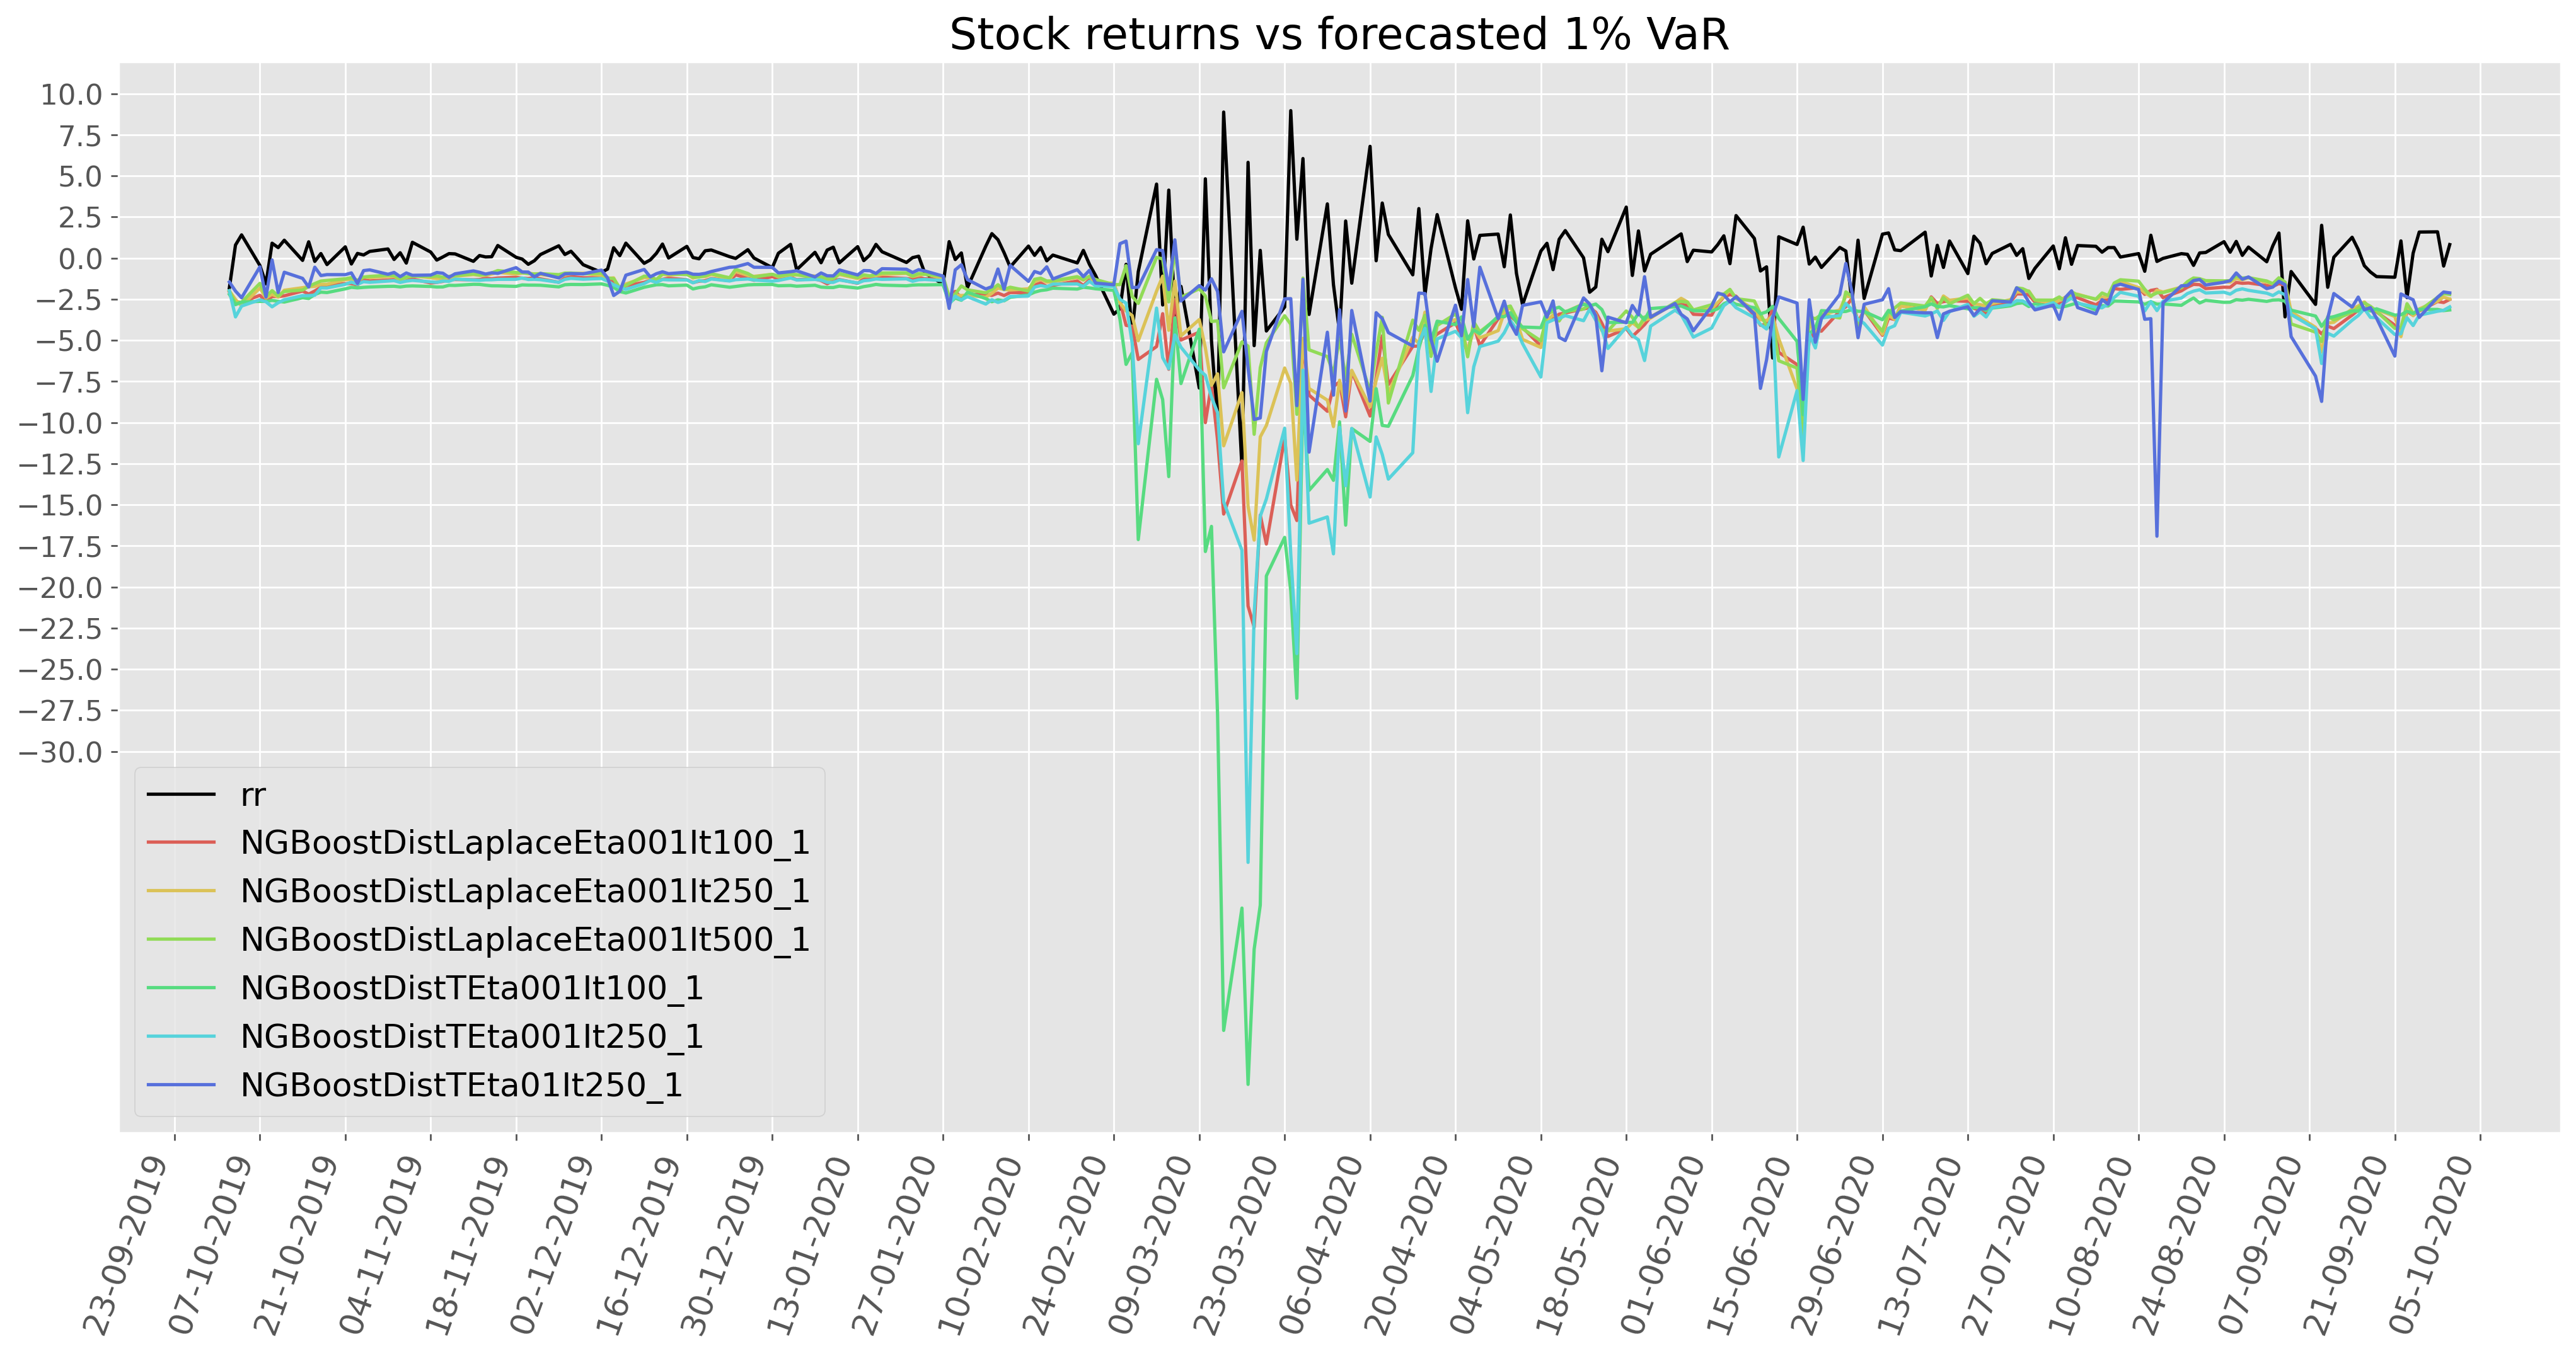

In [9]:
viz1_df = results.loc[:,(results.columns.str.endswith(("1","rr")))]

mpl.rcParams["figure.dpi"] = 250
plt.rcParams["figure.figsize"] = (20, 10)
cols = list(sns.color_palette("hls", 8))
cols.insert(0,(0,0,0))
ax = viz1_df.plot(color = cols)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()
plt.title("Stock returns vs forecasted 1% VaR", fontsize=20)
plt.xlabel("")
plt.legend(fontsize=15)
plt.xticks(rotation=70, fontsize=15)
plt.yticks(np.arange(-30,12.5, 2.5),fontsize=13)
plt.show()

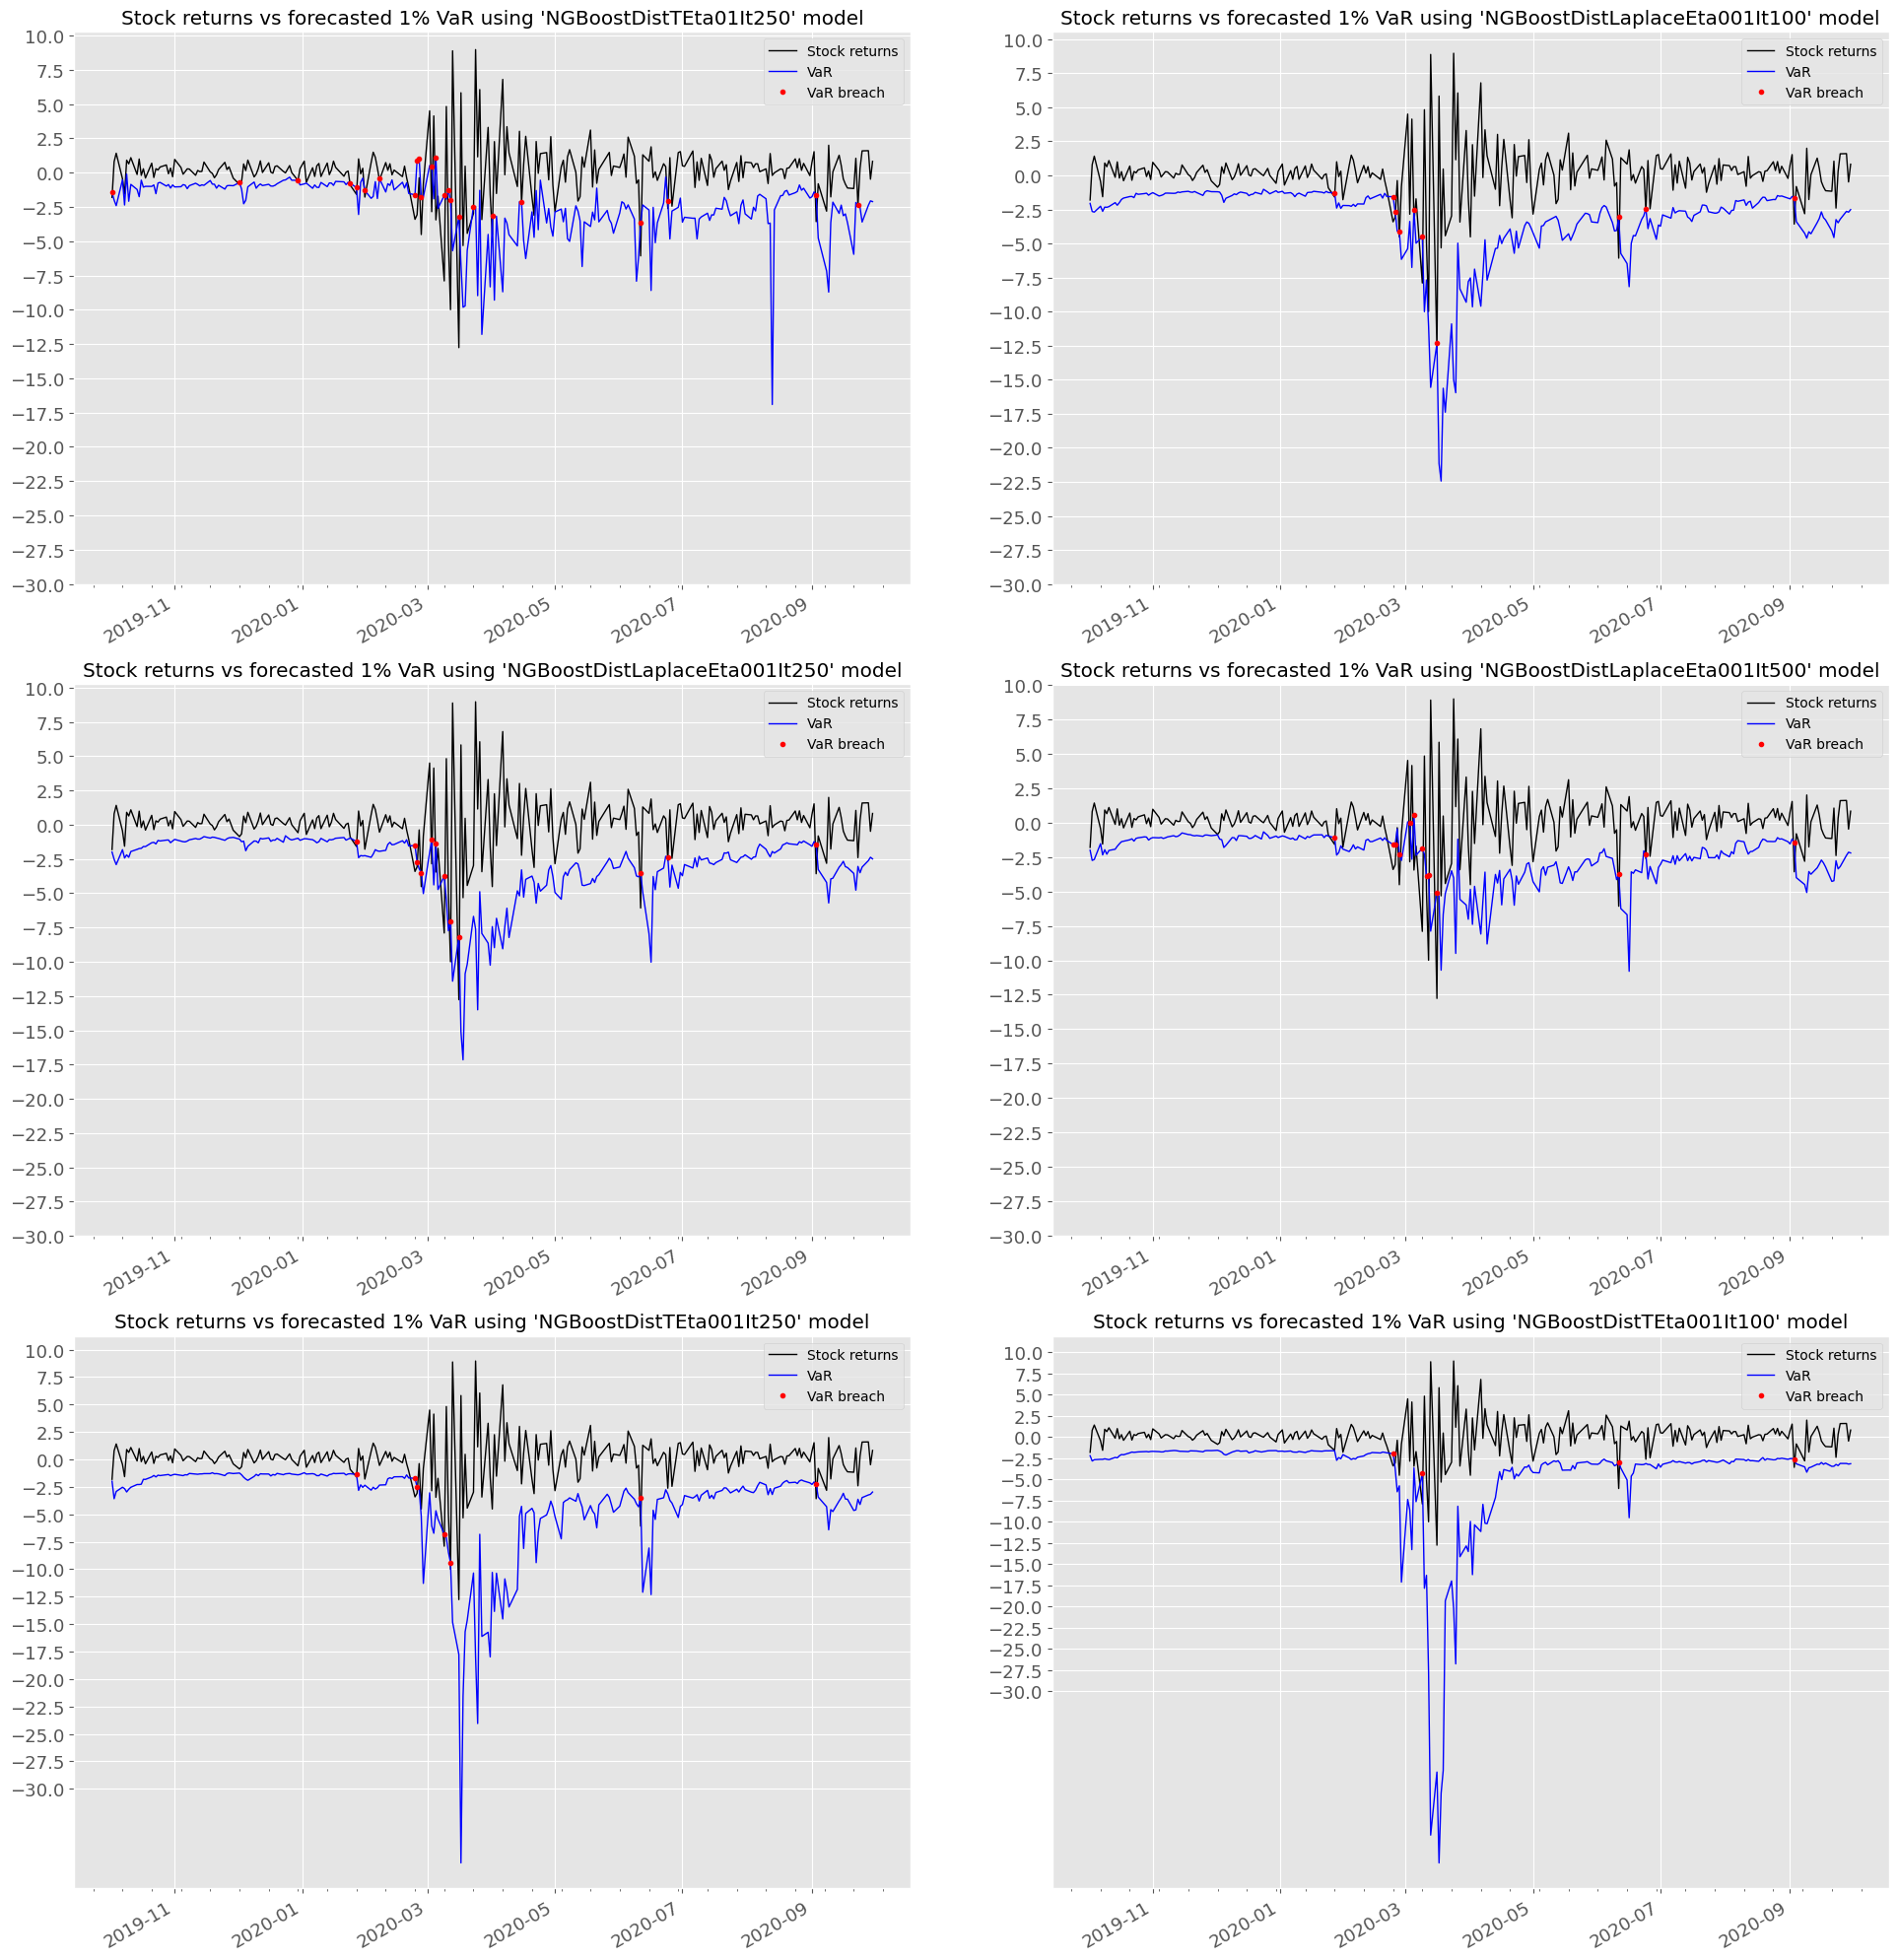

In [10]:
models_list = list(models)

mpl.rcParams["figure.dpi"] = 100
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
for i, ax in zip(range(0,6), axes.flat):
    name = models_list[i] + "_1"
    viz1_df["rr"].plot(color='black', linewidth=1, ax=ax)
    viz1_df[name].plot(color='blue', linewidth=1, ax=ax)
    ax.plot(viz1_df[name][viz1_df["rr"] < viz1_df[name]], color='red', linewidth=0, marker='.')
    ax.set_xlabel("")
    name_plot = "Stock returns vs forecasted 1% VaR using '" + name.split("_")[0] + "' model"
    ax.set_title(name_plot)
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_yticks(np.arange(-30,12.5, 2.5))
    ax.legend(["Stock returns","VaR","VaR breach"])
    
fig.tight_layout()
plt.show()

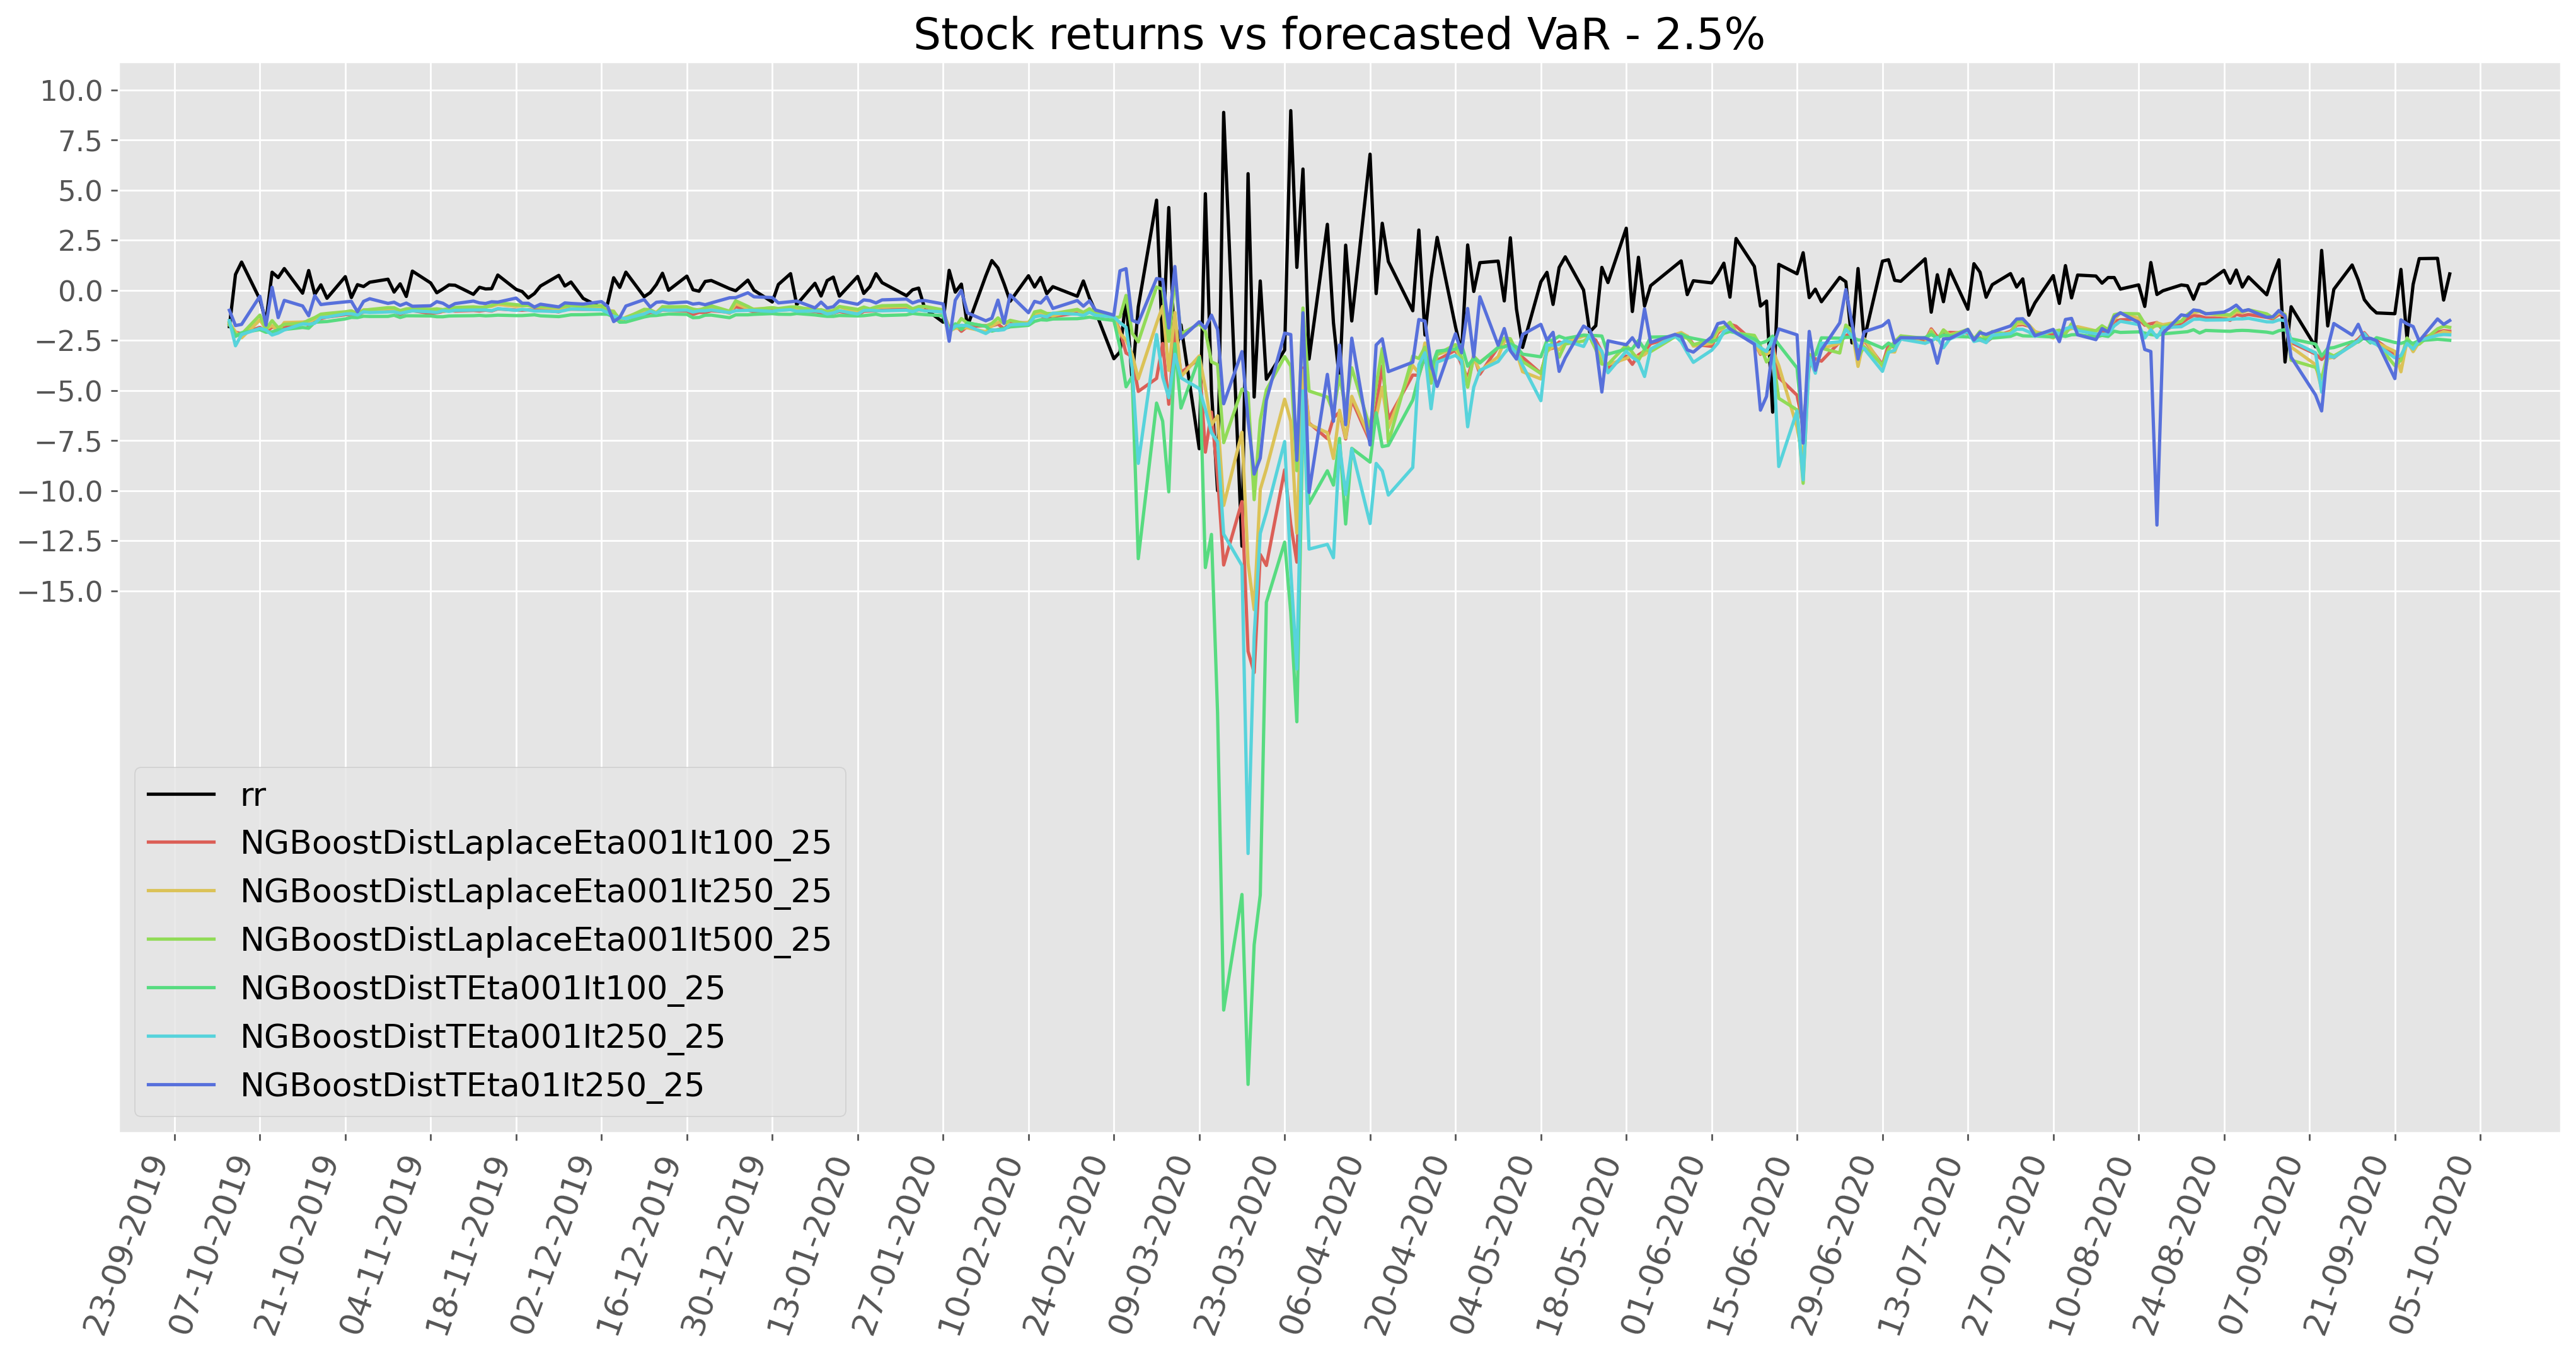

In [11]:
viz25_df = results.loc[:,(results.columns.str.endswith(("25","rr")))]

mpl.rcParams["figure.dpi"] = 250
plt.rcParams["figure.figsize"] = (20, 10)
cols = list(sns.color_palette("hls", 8))
cols.insert(0,(0,0,0))
ax = viz25_df.plot(color = cols)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()
plt.title("Stock returns vs forecasted VaR - 2.5%", fontsize=20)
plt.xlabel("")
plt.legend(fontsize=15)
plt.xticks(rotation=70, fontsize=15)
plt.yticks(np.arange(-15,12.5, 2.5),fontsize=13)
plt.show()

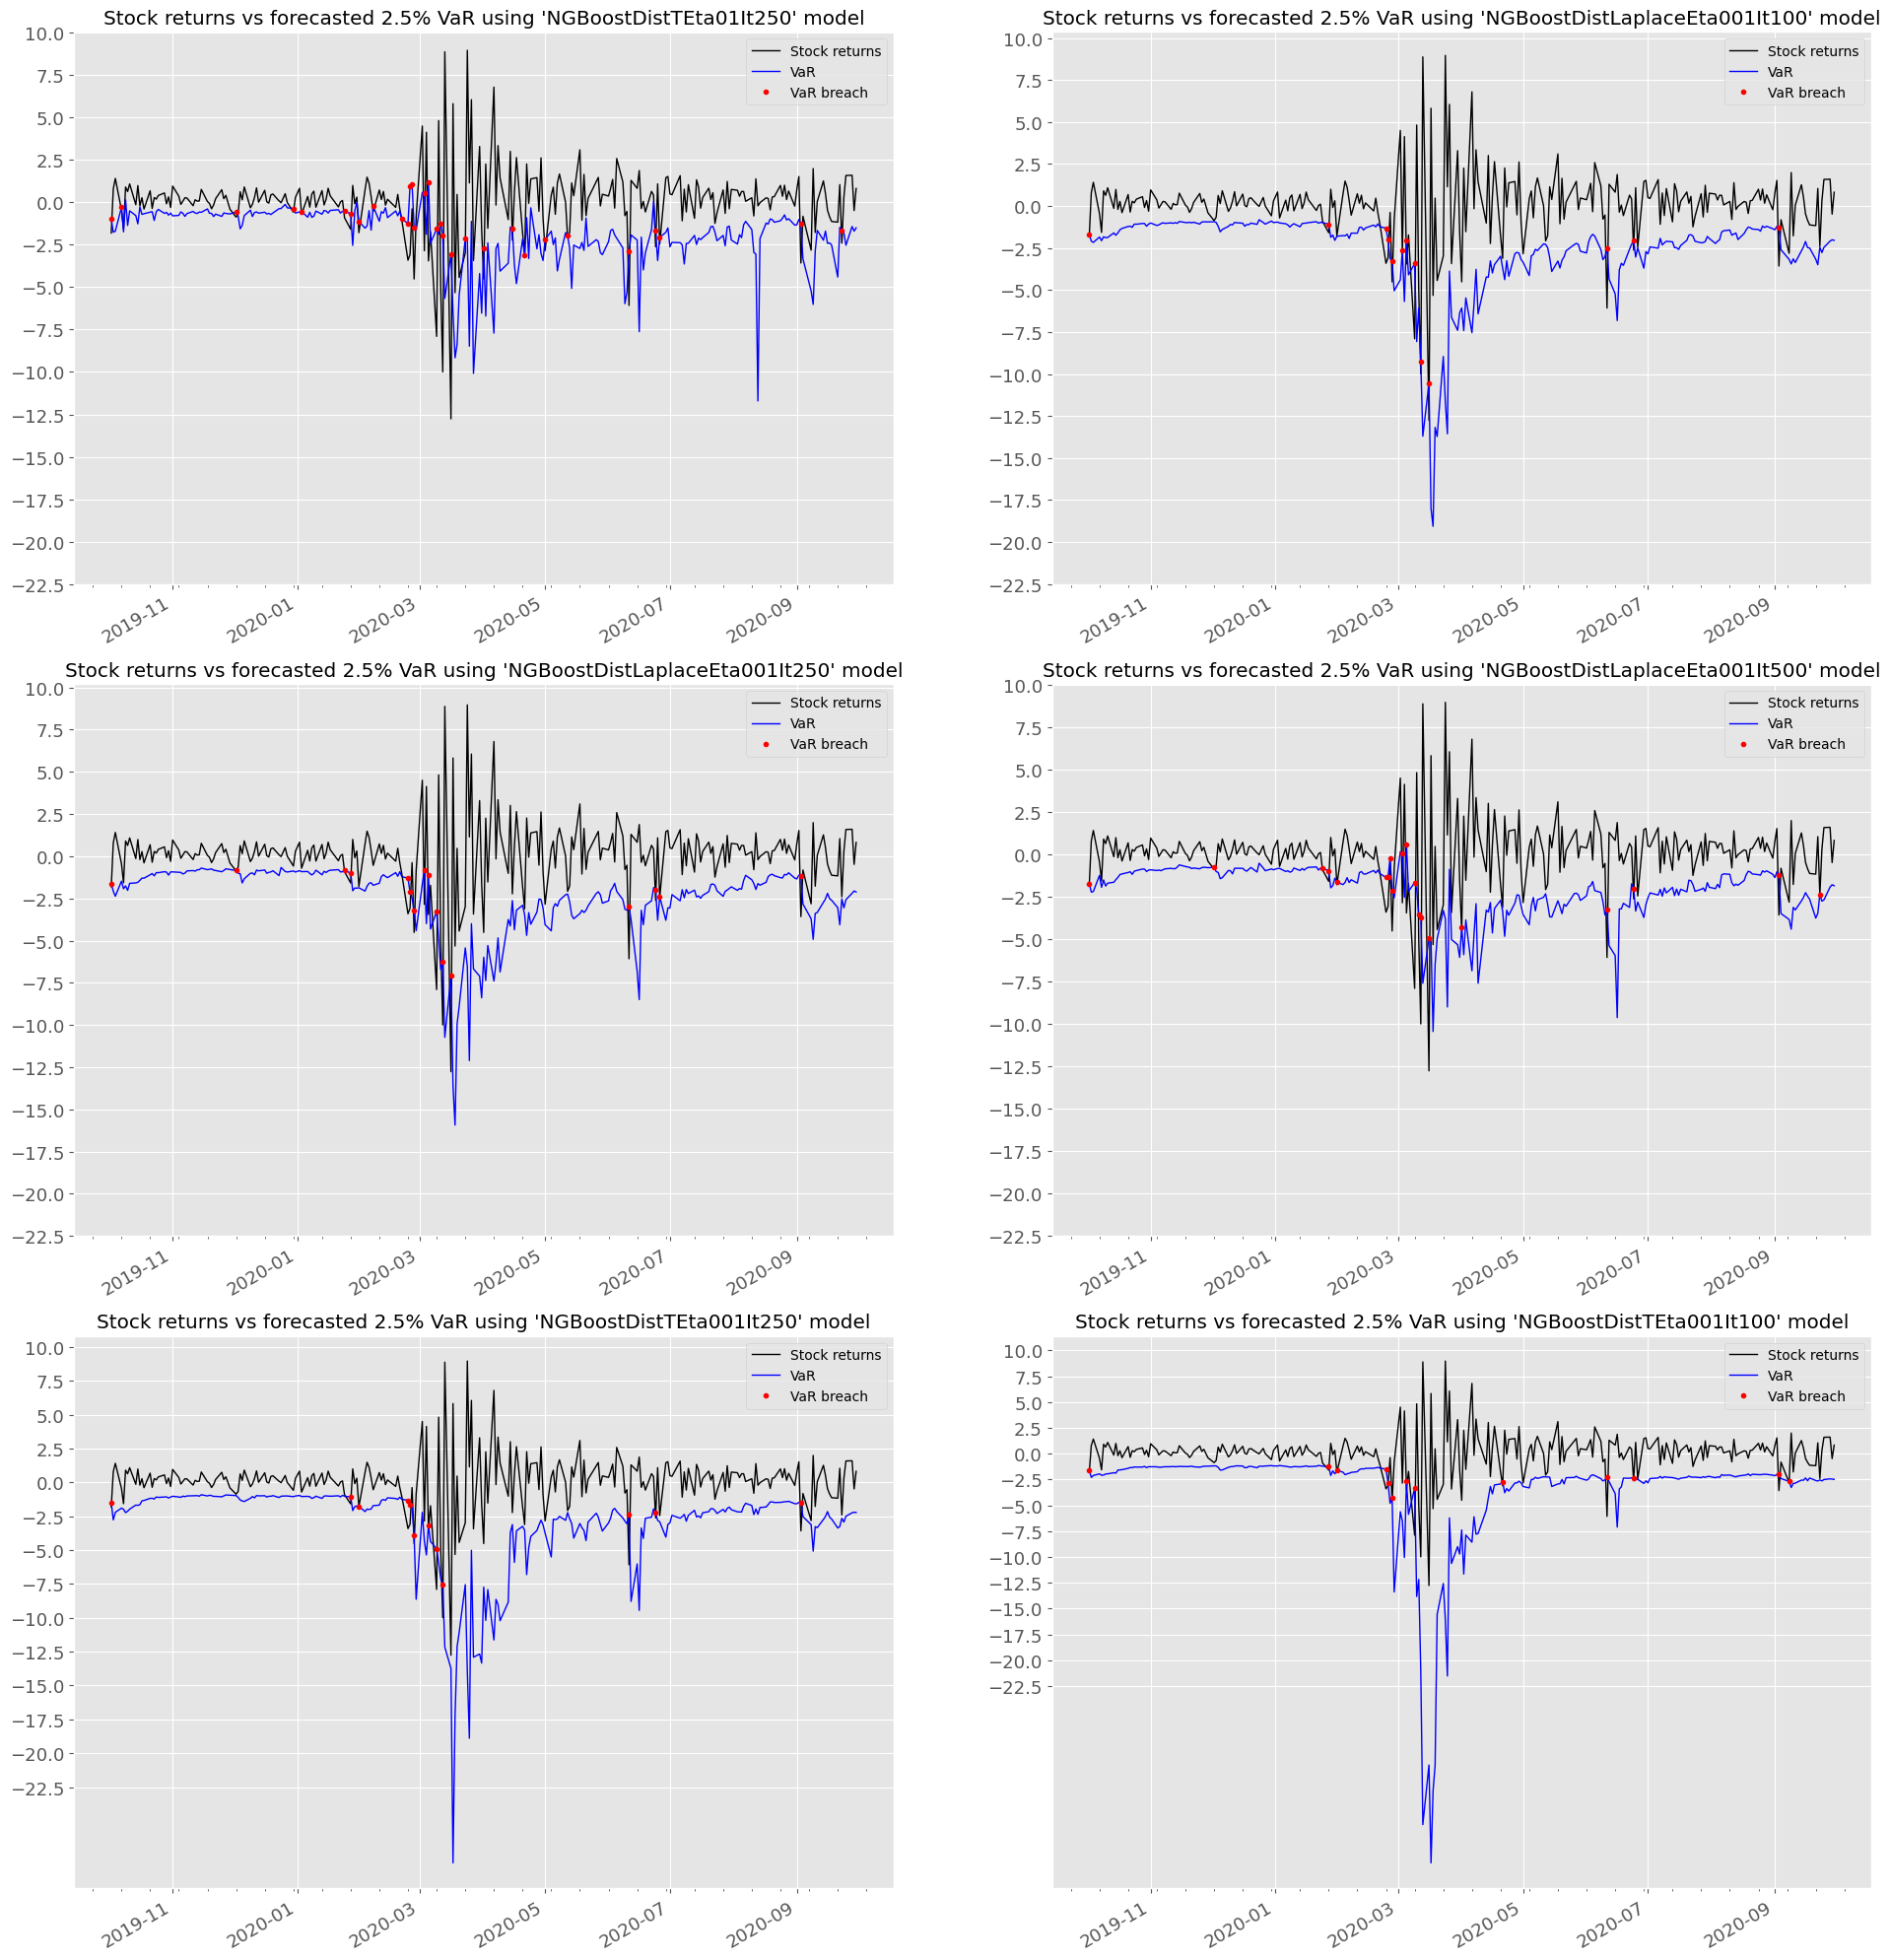

In [12]:
models_list = list(models)

mpl.rcParams["figure.dpi"] = 100
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
for i, ax in zip(range(0,6), axes.flat):
    name = models_list[i] + "_25"
    viz25_df["rr"].plot(color='black', linewidth=1, ax=ax)
    viz25_df[name].plot(color='blue', linewidth=1, ax=ax)
    ax.plot(viz25_df[name][viz25_df["rr"] < viz25_df[name]], color='red', linewidth=0, marker='.')
    ax.set_xlabel("")
    name_plot = "Stock returns vs forecasted 2.5% VaR using '" + name.split("_")[0] + "' model"
    ax.set_title(name_plot)
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_yticks(np.arange(-22.5,12.5, 2.5))
    ax.legend(["Stock returns","VaR","VaR breach"])
    
fig.tight_layout()
plt.show()

## The absolute number and the percentage of exceedances of the VaR level 

In [13]:
output_ex = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        ex = sum(results[name] > results["rr"])
        j = "2.5" if j == "25" else "1"
        output_ex.append([i,j,ex])

output_ex = pd.DataFrame(output_ex, columns = ["model","pval","exceed"])
output_cross_tab_ex_absolute = pd.pivot_table(output_ex, index = ['model'], columns=['pval'], values=['exceed'])
output_cross_tab_ex_percent = pd.pivot_table(output_ex, index = ['model'], columns=['pval'], values=['exceed'], margins=False, aggfunc='sum')/252*100

In [14]:
display(output_cross_tab_ex_absolute)
display(output_cross_tab_ex_percent)

exceed    
pval                               1 2.5
model                                   
NGBoostDistLaplaceEta001It100     10  13
NGBoostDistLaplaceEta001It250     12  16
NGBoostDistLaplaceEta001It500     13  20
NGBoostDistTEta001It100            4  13
NGBoostDistTEta001It250            7  12
NGBoostDistTEta01It250            24  31

exceed           
pval                                  1        2.5
model                                             
NGBoostDistLaplaceEta001It100  3.968254   5.158730
NGBoostDistLaplaceEta001It250  4.761905   6.349206
NGBoostDistLaplaceEta001It500  5.158730   7.936508
NGBoostDistTEta001It100        1.587302   5.158730
NGBoostDistTEta001It250        2.777778   4.761905
NGBoostDistTEta01It250         9.523810  12.301587

##  Kupiec test (unconditional coverage), Christoffersen test (conditional coverage) and Engle test (dynamic quantile)

In [15]:
output_test = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        realisation_array = results["rr"].values
        vars_array = results[name].values
        j = "2.5" if j == "25" else "1"
        p = 0.025 if j == "25" else 0.01
        test1 = kupiec_pof(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test2 = haas_dweibull(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test3 = christoffersen_ccov(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test4 = engle_dq (y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p, k = 3)["p-value"]
        output_test.append([i,j,test1, test2, test3, test4])

output_test = pd.DataFrame(output_test, columns = ["model","pval","kupiec_pof","haas_dweibull","christoffersen_ccov","engle_dq"])
output_cross_tab_test = pd.pivot_table(output_test, index = ['model'], columns=['pval'], values=['kupiec_pof','haas_dweibull','christoffersen_ccov','engle_dq']).round(3)

In [16]:
output_cross_tab_test

christoffersen_ccov      engle_dq       \
pval                                            1  2.5        1  2.5   
model                                                                  
NGBoostDistLaplaceEta001It100               0.000  0.0    0.000  0.0   
NGBoostDistLaplaceEta001It250               0.000  0.0    0.000  0.0   
NGBoostDistLaplaceEta001It500               0.000  0.0    0.000  0.0   
NGBoostDistTEta001It100                     0.440  0.0    0.869  0.0   
NGBoostDistTEta001It250                     0.002  0.0    0.000  0.0   
NGBoostDistTEta01It250                      0.000  0.0    0.000  0.0   

                              haas_dweibull        kupiec_pof       
pval                                      1    2.5          1  2.5  
model                                                               
NGBoostDistLaplaceEta001It100         0.125  0.019      0.000  0.0  
NGBoostDistLaplaceEta001It250         0.082  0.002      0.000  0.0  
NGBoostDistLaplaceEta001It500         0.092  0.000      0.000  0.0  
NGBoostDistTEta001It100               0.826  0.002      0.388  0.0  
NGBoostDistTEta001It250               0.488  0.020      0.020  0.0  
NGBoostDistTEta01It250                0.000  0.000      0.000  0.0

## Financial provisions

In [17]:
amount = 1e6 #USD
output_prov = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        prov = sum(abs(results[name].values) * amount)
        j = "2.5" if j == "25" else "1"
        output_prov.append([i,j,prov])

output_prov = pd.DataFrame(output_prov, columns = ["model","pval","prov"])
output_cross_prov = pd.pivot_table(output_prov, index = ['model'], columns=['pval'], values=['prov'])

In [18]:
output_cross_prov

prov              
pval                                      1           2.5
model                                                    
NGBoostDistLaplaceEta001It100  8.501365e+06  6.790158e+06
NGBoostDistLaplaceEta001It250  7.508140e+06  6.306025e+06
NGBoostDistLaplaceEta001It500  6.386093e+06  5.462373e+06
NGBoostDistTEta001It100        1.152356e+07  8.828872e+06
NGBoostDistTEta001It250        1.030755e+07  7.732080e+06
NGBoostDistTEta01It250         6.252439e+06  4.790141e+06

## VaR breach vs  financial provisions

In [19]:
viz_ex_prov_1 = pd.merge(output_cross_prov[('prov',   '1')], output_cross_tab_ex_absolute[('exceed',   '1')], left_index=True, right_index=True)
viz_ex_prov_25 = pd.merge(output_cross_prov[('prov',   '2.5')], output_cross_tab_ex_absolute[('exceed',   '2.5')], left_index=True, right_index=True)

viz_ex_prov_1.columns = ["prov", "exceed"]
viz_ex_prov_25.columns = ["prov", "exceed"]

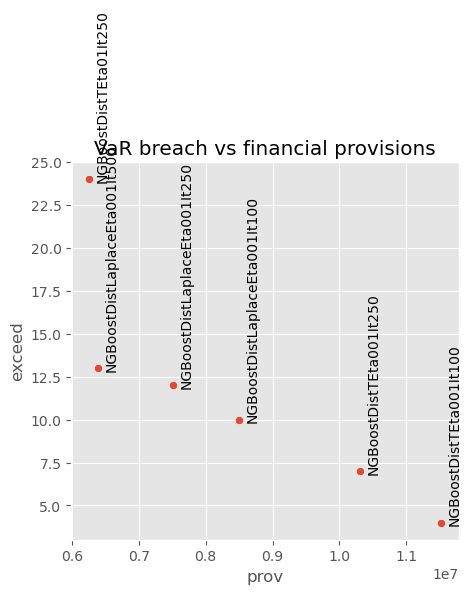

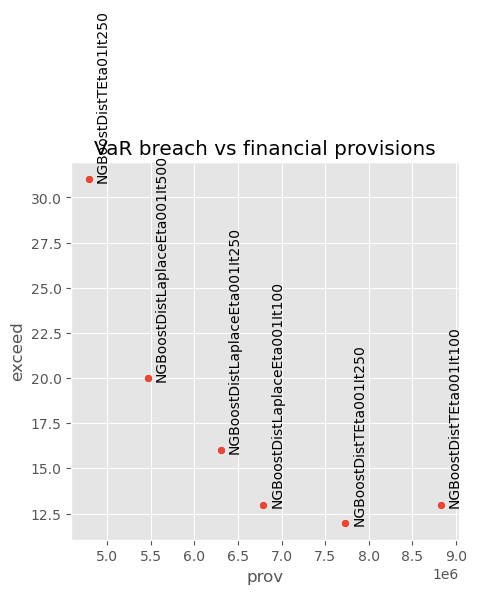

In [20]:
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=viz_ex_prov_1, x="prov", y="exceed")
plt.title("VaR breach vs financial provisions")

for x, y, z in zip(viz_ex_prov_1.prov, viz_ex_prov_1.exceed, viz_ex_prov_1.index):
    label = z
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=90)

plt.show()

mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=viz_ex_prov_25, x="prov", y="exceed")
plt.title("VaR breach vs financial provisions")

for x, y, z in zip(viz_ex_prov_25.prov, viz_ex_prov_25.exceed, viz_ex_prov_25.index):
    label = z
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=90)

plt.show()